<a href="https://colab.research.google.com/github/statscol/icesi_faii_final/blob/master/fundamentos_analiticaII_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller Fundamentos de Analítica 2

## Jhon Parra - Jhon López

El dataset "TransaccionesBancarias.csv" contiene la historia transaccional de diferentes clientes a los que se les otorgó un crédito bancario. Se trata de las agregaciones de las operaciones diarias de los 3 meses (90 días) previos a la demanda del crédito. Tenemos además la fecha del crédito, el monto prestado, y una indicación de si el cliente pudo cumplir con sus obligaciones de pago o no.


## **Carga de librerías necesarias**





Se realiza la carga de las librerias necesarias para efectuar el proceso de limpieza, procesamiento (featuring engineer), modelamiento, y prueba.

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
from plotnine import *
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import cohen_kappa_score,accuracy_score,f1_score
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import SGDClassifier
import imblearn


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## **Lectura de la información**

In [2]:
##READ FROM GITHUB REPO
!git clone https://github.com/statscol/icesi_faii_final
%ls

Cloning into 'icesi_faii_final'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 34 (delta 18), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.
icesi_faii_final/  sample_data/


In [3]:
datos=pd.read_csv("icesi_faii_final/TransaccionesBancarias.csv")
datos.head()


,ID,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6,dia_7,dia_8,dia_9,dia_10,dia_11,dia_12,dia_13,dia_14,dia_15,dia_16,dia_17,dia_18,dia_19,dia_20,dia_21,dia_22,dia_23,dia_24,dia_25,dia_26,dia_27,dia_28,dia_29,dia_30,dia_31,dia_32,dia_33,dia_34,dia_35,dia_36,dia_37,dia_38,dia_39,...,dia_54,dia_55,dia_56,dia_57,dia_58,dia_59,dia_60,dia_61,dia_62,dia_63,dia_64,dia_65,dia_66,dia_67,dia_68,dia_69,dia_70,dia_71,dia_72,dia_73,dia_74,dia_75,dia_76,dia_77,dia_78,dia_79,dia_80,dia_81,dia_82,dia_83,dia_84,dia_85,dia_86,dia_87,dia_88,dia_89,dia_90,pago,fecha,monto
0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,-3500.00,...,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,-30.0,0.0,0.0,-102.00,0.0,0.0,0.00,0.00,0.0,-488.43,0.0,0.0,0.0,0.0,-20.0,-5743.11,NO,2019-04-16 10:55:50.111,150.0
1,2,20323.83,0.00,0.00,1149.58,-807.37,1240.97,1189.47,-11766.97,0.00,0.00,-277.23,1911.71,-3333.63,1351.12,-994.11,0.00,0.00,-2584.20,1490.1,1497.91,909.02,-2552.57,0.00,0.00,1369.02,-2527.99,1349.96,-2708.84,-948.15,0.00,0.00,1751.82,1523.25,2105.0,1785.60,526.27,0.00,0.00,299.15,...,1490.23,1470.19,1744.23,0.0,0.0,0.0,-270.07,1590.93,-7581.79,-3303.89,1256.7,0.0,0.0,1224.79,-1671.22,1303.49,-3220.97,1509.8,0.0,0.0,-1490.2,1509.8,0.0,0.0,-3034.03,0.0,0.0,1323.34,1323.34,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-04-16 16:15:32.991,100.0
2,3,0.00,0.00,-7.15,-7.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-150.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.0,0.0,-30.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-30.0,0.0,0.00,NO,2019-04-29 17:47:37.833,100.0
3,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,-40.34,-138.75,0.00,0.00,0.00,0.00,-7.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.0,0.0,-7.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-7.0,0.0,0.00,NO,2019-04-29 20:28:54.543,100.0
4,6,17.02,188.69,-62.19,288.53,0.00,0.00,-266.58,-6.97,103.49,-41.82,-831.44,0.00,0.00,288.96,87.07,63.04,-630.05,960.54,0.0,0.00,32.29,14.70,-365.65,-261.43,18.39,0.00,0.00,304.50,212.35,27.61,-310.73,524.48,0.00,0.0,-230.03,6.25,84.03,-115.45,395.57,...,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-05-03 14:46:39.028,900.0


## Limpieza y Transformación de la Información

En el proceso de transformación de la información se crean diferentes variables a partir de las ya existentes en el data set.

Dentro de las variables creadas se tiene:
1. TotalMovMes1 es el resumen del total de movimentos efectuados por un cliente en el mes 1 (suma de movimientos en el mes). 
2. TotalMovMes2 es el resumen del total de movimentos efectuados por un cliente en el mes 2 (suma de movimientos en el mes).  
3. TotalMovMes3 es el resumen del total de movimentos efectuados por un cliente en el mes 3 (suma de movimientos en el mes). 

In [0]:
datos=datos.set_index(['ID'])

Ahora se crean variables para estudiar el numero de negativos, positivos o no no movimientos, cuando se habla de movimientos negativos  se hace referencia a debitos, movimientos positivos a creditos.

Teniendo en cuenta lo anterior, se calcula el numero de movimientos de debito, de credito y no movimientos en cada uno de los meses.
 
Mes1_NoMov: Numero de dias sin movimientos
Mes1_MovInt: Numero de dias con movimientos de credito
Mes1_MovOut: Numero de dias con movimientos de debito

Esto se calcula para los 3 meses.

In [0]:
#cambiar a tipo fecha
datos['fecha']=pd.to_datetime(datos.fecha) 

###creacion de variables 
datos['TotalMovMes1']=datos.iloc[:,1:31].sum(axis=1)
datos['TotalMovMes2']=datos.iloc[:,31:61].sum(axis=1)
datos['TotalMovMes3']=datos.iloc[:,61:91].sum(axis=1)

def dicotomizacion(x):
  if x>0:
    return(1)
  elif(x<0):
    return(-1)
  else:
    return(0)


VarsMovs=pd.DataFrame(datos.iloc[:,0:90].apply(lambda x:[dicotomizacion(a) for a in x],axis=0))
VarsMovs.columns=['Dico'+'_' + s1 for s1 in VarsMovs.columns]
VarsMovs.head()


VarsMovs['Mes1_NoMov']=(VarsMovs.iloc[:,0:30]==0).astype(int).sum(axis=1)
VarsMovs['Mes1_MovInt']=(VarsMovs.iloc[:,0:30]==1).astype(int).sum(axis=1)
VarsMovs['Mes1_MovOut']=(VarsMovs.iloc[:,0:30]==-1).astype(int).sum(axis=1)

VarsMovs['Mes2_NoMov']=(VarsMovs.iloc[:,30:60]==0).astype(int).sum(axis=1)
VarsMovs['Mes2_MovInt']=(VarsMovs.iloc[:,30:60]==1).astype(int).sum(axis=1)
VarsMovs['Mes2_MovOut']=(VarsMovs.iloc[:,30:60]==-1).astype(int).sum(axis=1)

VarsMovs['Mes3_NoMov']=(VarsMovs.iloc[:,60:90]==0).astype(int).sum(axis=1)
VarsMovs['Mes3_MovInt']=(VarsMovs.iloc[:,60:90]==1).astype(int).sum(axis=1)
VarsMovs['Mes3_MovOut']=(VarsMovs.iloc[:,60:90]==-1).astype(int).sum(axis=1)




In [6]:
VarsMovs=VarsMovs.reset_index()
datos=datos.reset_index()

VarsFinal=VarsMovs.loc[:,['ID','Mes1_NoMov','Mes1_MovInt','Mes1_MovOut',
                'Mes2_NoMov','Mes2_MovInt','Mes2_MovOut',
                'Mes3_NoMov','Mes3_MovInt','Mes3_MovOut']]

VarsFinal

,ID,Mes1_NoMov,Mes1_MovInt,Mes1_MovOut,Mes2_NoMov,Mes2_MovInt,Mes2_MovOut,Mes3_NoMov,Mes3_MovInt,Mes3_MovOut
0,1,29,0,1,28,0,2,25,0,5
1,2,9,11,10,10,15,5,16,8,6
2,3,27,0,3,27,0,3,29,0,1
3,5,28,0,2,28,0,2,29,0,1
4,6,8,14,8,20,6,4,30,0,0
...,...,...,...,...,...,...,...,...,...,...
1373,1481,29,0,1,30,0,0,30,0,0
1374,1482,7,10,13,8,9,13,6,9,15
1375,1483,6,6,18,1,11,18,5,7,18
1376,1484,8,3,19,14,4,12,29,1,0


Se unen las variables donde se evidencian los numeros de dias en función de el tipo de movimiento (debito, credito o sin movimiento)

In [7]:
DatosFinal=pd.merge(datos,VarsFinal,how='left',on='ID')

DatosFinal.head()


,ID,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6,dia_7,dia_8,dia_9,dia_10,dia_11,dia_12,dia_13,dia_14,dia_15,dia_16,dia_17,dia_18,dia_19,dia_20,dia_21,dia_22,dia_23,dia_24,dia_25,dia_26,dia_27,dia_28,dia_29,dia_30,dia_31,dia_32,dia_33,dia_34,dia_35,dia_36,dia_37,dia_38,dia_39,...,dia_66,dia_67,dia_68,dia_69,dia_70,dia_71,dia_72,dia_73,dia_74,dia_75,dia_76,dia_77,dia_78,dia_79,dia_80,dia_81,dia_82,dia_83,dia_84,dia_85,dia_86,dia_87,dia_88,dia_89,dia_90,pago,fecha,monto,TotalMovMes1,TotalMovMes2,TotalMovMes3,Mes1_NoMov,Mes1_MovInt,Mes1_MovOut,Mes2_NoMov,Mes2_MovInt,Mes2_MovOut,Mes3_NoMov,Mes3_MovInt,Mes3_MovOut
0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,-3500.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,-30.0,0.0,0.0,-102.00,0.0,0.0,0.00,0.00,0.0,-488.43,0.0,0.0,0.0,0.0,-20.0,-5743.11,NO,2019-04-16 10:55:50.111,150.0,-30.00,-3530.00,-6383.54,29,0,1,28,0,2,25,0,5
1,2,20323.83,0.00,0.00,1149.58,-807.37,1240.97,1189.47,-11766.97,0.00,0.00,-277.23,1911.71,-3333.63,1351.12,-994.11,0.00,0.00,-2584.20,1490.1,1497.91,909.02,-2552.57,0.00,0.00,1369.02,-2527.99,1349.96,-2708.84,-948.15,0.00,0.00,1751.82,1523.25,2105.0,1785.60,526.27,0.00,0.00,299.15,...,0.0,1224.79,-1671.22,1303.49,-3220.97,1509.8,0.0,0.0,-1490.2,1509.8,0.0,0.0,-3034.03,0.0,0.0,1323.34,1323.34,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-04-16 16:15:32.991,100.0,-15042.20,14736.95,-10850.84,9,11,10,10,15,5,16,8,6
2,3,0.00,0.00,-7.15,-7.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-150.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-30.0,0.0,0.00,NO,2019-04-29 17:47:37.833,100.0,-194.30,-3530.00,-30.00,27,0,3,27,0,3,29,0,1
3,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,-40.34,-138.75,0.00,0.00,0.00,0.00,-7.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-7.0,0.0,0.00,NO,2019-04-29 20:28:54.543,100.0,-186.09,-7.00,-7.00,28,0,2,28,0,2,29,0,1
4,6,17.02,188.69,-62.19,288.53,0.00,0.00,-266.58,-6.97,103.49,-41.82,-831.44,0.00,0.00,288.96,87.07,63.04,-630.05,960.54,0.0,0.00,32.29,14.70,-365.65,-261.43,18.39,0.00,0.00,304.50,212.35,27.61,-310.73,524.48,0.00,0.0,-230.03,6.25,84.03,-115.45,395.57,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-05-03 14:46:39.028,900.0,-186.70,752.36,0.00,8,14,8,20,6,4,30,0,0


Ahota se implementan dos variables que hacen referencia a el promedio de movimientos en los ultimos 15 dias antes al pago y tambien la suma general de todos los movimientos (suma de 90 dias).

In [0]:
DatosFinal['Prom_15lastdays']=DatosFinal.iloc[:,75:91].mean(axis=1)
DatosFinal['SumMov']=DatosFinal.iloc[:,1:91].sum(axis=1)
DatosFinal['PromCliente']=DatosFinal.iloc[:,1:91].mean(axis=1)
DatosFinal['StdCliente']=DatosFinal.iloc[:,1:91].std(axis=1)




Ahora bien es necesario volver la variable de interes (PAGO) una variable dummy

In [10]:
#pago: cambiar a binaria. 1 si no pagó, 0 si pagó
DatosFinal['pago_m']=pd.get_dummies(DatosFinal.pago)["NO"]
#DatosFinal=DatosFinal.drop(['index'],axis=1)
#DatosFinal=DatosFinal.drop(['level_0'],axis=1)
DatosFinal.head()


,ID,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6,dia_7,dia_8,dia_9,dia_10,dia_11,dia_12,dia_13,dia_14,dia_15,dia_16,dia_17,dia_18,dia_19,dia_20,dia_21,dia_22,dia_23,dia_24,dia_25,dia_26,dia_27,dia_28,dia_29,dia_30,dia_31,dia_32,dia_33,dia_34,dia_35,dia_36,dia_37,dia_38,dia_39,...,dia_71,dia_72,dia_73,dia_74,dia_75,dia_76,dia_77,dia_78,dia_79,dia_80,dia_81,dia_82,dia_83,dia_84,dia_85,dia_86,dia_87,dia_88,dia_89,dia_90,pago,fecha,monto,TotalMovMes1,TotalMovMes2,TotalMovMes3,Mes1_NoMov,Mes1_MovInt,Mes1_MovOut,Mes2_NoMov,Mes2_MovInt,Mes2_MovOut,Mes3_NoMov,Mes3_MovInt,Mes3_MovOut,Prom_15lastdays,SumMov,PromCliente,StdCliente,pago_m
0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,-3500.00,...,0.0,0.0,0.0,0.0,-30.0,0.0,0.0,-102.00,0.0,0.0,0.00,0.00,0.0,-488.43,0.0,0.0,0.0,0.0,-20.0,-5743.11,NO,2019-04-16 10:55:50.111,150.0,-30.00,-3530.00,-6383.54,29,0,1,28,0,2,25,0,5,-398.971250,-9943.54,-110.483778,706.206677,1
1,2,20323.83,0.00,0.00,1149.58,-807.37,1240.97,1189.47,-11766.97,0.00,0.00,-277.23,1911.71,-3333.63,1351.12,-994.11,0.00,0.00,-2584.20,1490.1,1497.91,909.02,-2552.57,0.00,0.00,1369.02,-2527.99,1349.96,-2708.84,-948.15,0.00,0.00,1751.82,1523.25,2105.0,1785.60,526.27,0.00,0.00,299.15,...,1509.8,0.0,0.0,-1490.2,1509.8,0.0,0.0,-3034.03,0.0,0.0,1323.34,1323.34,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-04-16 16:15:32.991,100.0,-15042.20,14736.95,-10850.84,9,11,10,10,15,5,16,8,6,70.153125,9167.74,101.863778,2908.541165,1
2,3,0.00,0.00,-7.15,-7.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-150.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-30.0,0.0,0.00,NO,2019-04-29 17:47:37.833,100.0,-194.30,-3530.00,-30.00,27,0,3,27,0,3,29,0,1,-1.875000,-3754.30,-41.714444,369.005553,1
3,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,-40.34,-138.75,0.00,0.00,0.00,0.00,-7.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-7.0,0.0,0.00,NO,2019-04-29 20:28:54.543,100.0,-186.09,-7.00,-7.00,28,0,2,28,0,2,29,0,1,-0.437500,-200.09,-2.223222,15.206826,1
4,6,17.02,188.69,-62.19,288.53,0.00,0.00,-266.58,-6.97,103.49,-41.82,-831.44,0.00,0.00,288.96,87.07,63.04,-630.05,960.54,0.0,0.00,32.29,14.70,-365.65,-261.43,18.39,0.00,0.00,304.50,212.35,27.61,-310.73,524.48,0.00,0.0,-230.03,6.25,84.03,-115.45,395.57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-05-03 14:46:39.028,900.0,-186.70,752.36,0.00,8,14,8,20,6,4,30,0,0,0.000000,582.68,6.474222,191.563784,1


## Análisis Exploratorio

Teniendo en cueta las variables creadas y la ya existente se procede a realizar un analisis descriptivo que pemtira identificar que variables pueden ayudar a diferenciar cuando una persona pagará o no un credito.

Se muestra el comportamiento de los pagos, se ilustra el BASELINE. Se evidencia que los datos estan desbalanceados, el 83,5% de los clientes pagan los creditos y el 16,47% no los pagan.

In [0]:
Baseline=pd.DataFrame({'Count':DatosFinal.groupby(['pago']).size()})
Baseline=Baseline.reset_index()
Baseline['Prop']=Baseline['Count']/Baseline['Count'].sum()


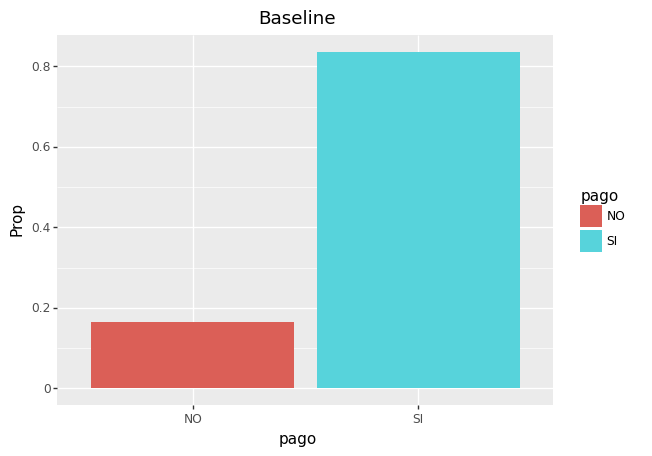

<ggplot: (8734589526136)>

In [0]:
ggplot(aes(x='pago',y='Prop',fill='pago'),data=Baseline)+\
geom_col()+ggtitle('Baseline')


Se evidencia que hay mayor concentración del no pago de los creditos en prestamos de menores montos. 

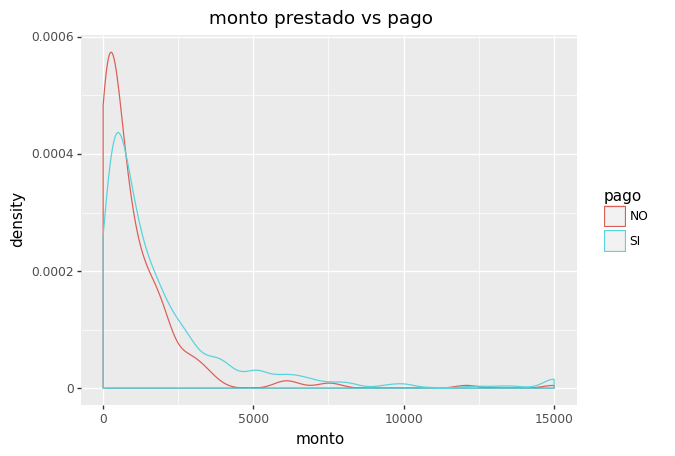

<ggplot: (-9223363274760495700)>

In [0]:
ggplot(aes(x='monto',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('monto prestado vs pago')

Se crea una variable que permita particionar el nivel del monto que se le ha prestado al cliente

In [0]:
DatosFinal['MontoCat']=DatosFinal['monto'].apply(lambda x: 'Menos de 5000' if x<=5000 else (
 '5000-10000' if x>5000 and x<=10000 else ('Mas de 10000')))

In [12]:
CuentaMontoCat=DatosFinal.groupby(['MontoCat','pago']).size().reset_index(name="count")
CategoricalDtype(categories=['Menos de 50000','5000-10000' 'Gold'], ordered=True)
CuentaMontoCat['MontoCat']=pd.Categorical(CuentaMontoCat['MontoCat'],ordered=True,categories=['Menos de 5000','5000-10000','Mas de 10000'])
CuentaMontoCat

,MontoCat,pago,count
0,5000-10000,NO,5
1,5000-10000,SI,82
2,Mas de 10000,NO,2
3,Mas de 10000,SI,28
4,Menos de 5000,NO,220
5,Menos de 5000,SI,1041


Se ilustra el comportamiento del nivel del monto prestado y si el cliente paga o no, se observa que la gran mayoria de los prestamos que no son pagados son menores a los US 5000, 5 creditos que estan entre los 5000 y los 10000 son no pagados y solo 2 de mas de 10000 no son pagados. 

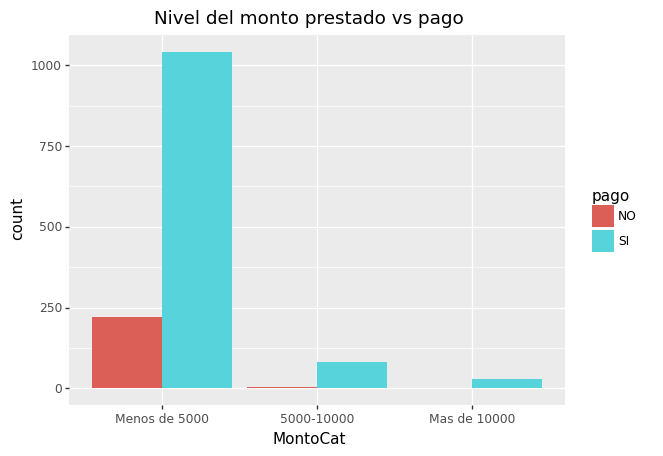

<ggplot: (-9223363274764221205)>

In [0]:
ggplot(aes(x='MontoCat',y='count',fill='pago'),data=CuentaMontoCat)+\
geom_col(position=position_dodge())+ggtitle('Nivel del monto prestado vs pago')

Se estudio el resumen de los movimientos  realizados por los clientes en los primeros 30 días y se relacionan con el pago o no pago del credito
No es posible evidenciar diferencias muy marcadas.


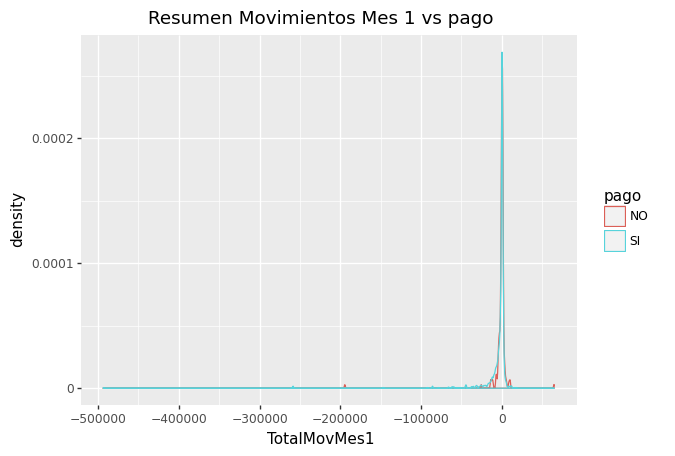

<ggplot: (8769324519944)>

In [0]:
ggplot(aes(x='TotalMovMes1',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Resumen Movimientos Mes 1 vs pago')

Se estudio el resumen de los movimientos  realizados por los clientes en los segundos 30 días y se relacionan con el pago o no pago del credito
No es posible evidenciar diferencias muy marcadas.


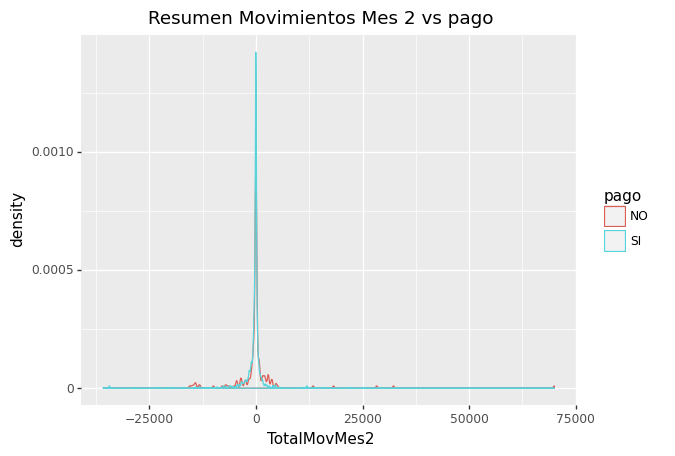

<ggplot: (-9223363267530314229)>

In [0]:
ggplot(aes(x='TotalMovMes2',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Resumen Movimientos Mes 2 vs pago')


Se estudio el resumen de los movimientos  realizados por los clientes en los ultimos 30 días y se relacionan con el pago o no pago del credito
No es posible evidenciar diferencias muy marcadas.


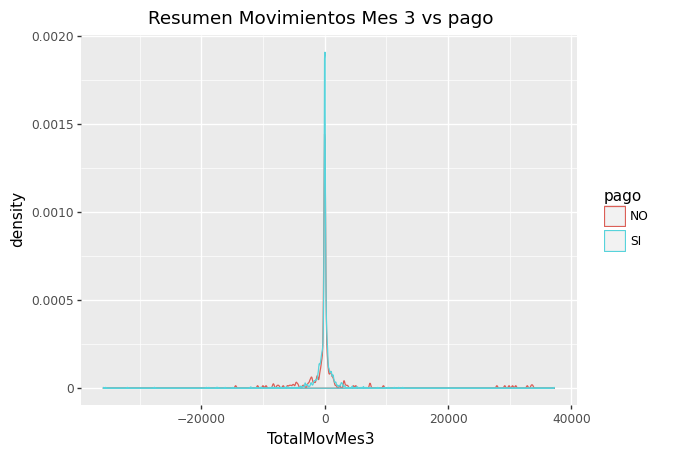

<ggplot: (-9223363267530339917)>

In [0]:
ggplot(aes(x='TotalMovMes3',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Resumen Movimientos Mes 3 vs pago')


Ahora bien, se estudia el tipo de movimientos en cada uno de los meses, lo clientes pueden no tener movimientos en sus cuentas, pueden tener movimientos negativos los cuales hacen referencia a debitos en sus cuentas o pagos realizados y por ultimo, se encuentran los movimientos positivos los cuales evidencia un credito o la entrada de dinero a sus cuentas.

Clientes sin movimientos y su comportamiento de pago o no pago:

Al revisar el numero de dias sin movimientos en cada uno de los 3 meses disponibles se evidencia que los cliente que pagan sus creditos principalmente tienen entre 10 y 12 dias sin movimientos.

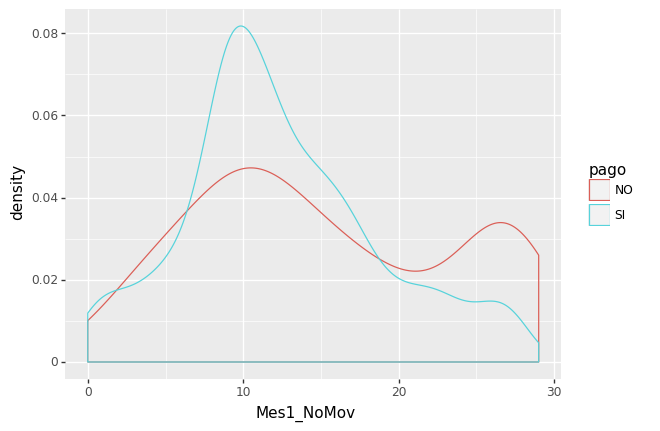

<ggplot: (-9223363267530399053)>

In [0]:
ggplot(aes(x='Mes1_NoMov',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Dias sin movimientos en el mes 1 vs pago')

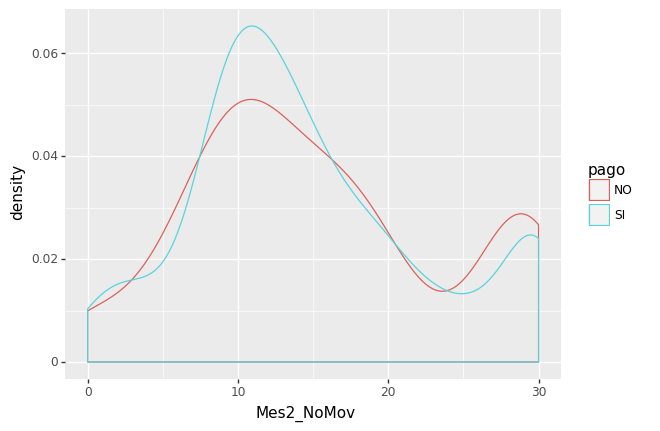

<ggplot: (-9223363267530411867)>

In [0]:
ggplot(aes(x='Mes2_NoMov',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Dias sin movimientos en el mes 2 vs pago')

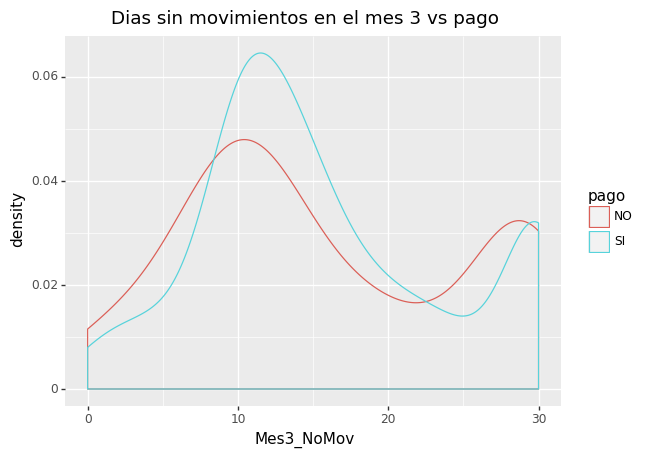

<ggplot: (8769324310343)>

In [0]:
ggplot(aes(x='Mes3_NoMov',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Dias sin movimientos en el mes 3 vs pago')



Por otro lado, se evaluan el numero de dias con movimientos de creditos segun en función de que el cliente pague o no el credito.

Se observa que en cada uno de los 3 meses en estudio los clientes que pagan los creditos principalmente tienen 5 movimientos de credito.

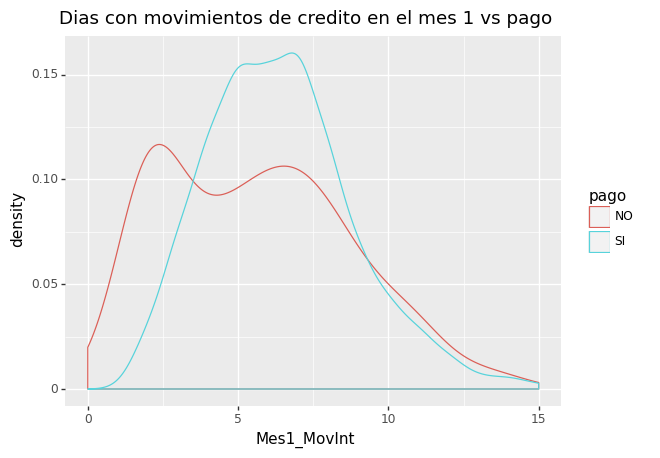

<ggplot: (-9223363267530378552)>

In [0]:
ggplot(aes(x='Mes1_MovInt',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Dias con movimientos de credito en el mes 1 vs pago')



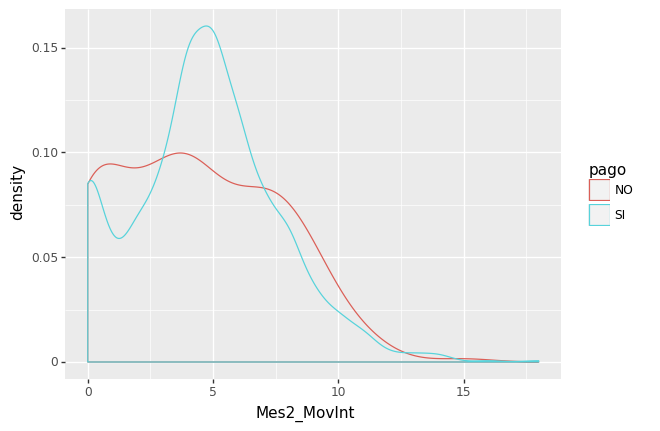

<ggplot: (8782559805490)>

In [0]:
ggplot(aes(x='Mes2_MovInt',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Dias con movimientos de credito en el mes 2 vs pago')


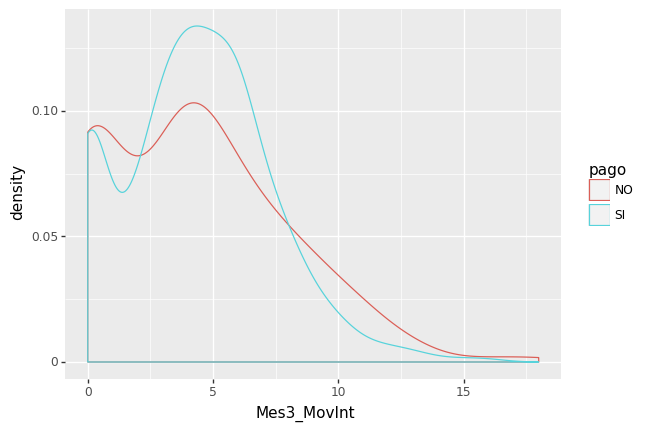

<ggplot: (-9223363267530467440)>

In [0]:
ggplot(aes(x='Mes3_MovInt',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Dias con movimientos de credito en el mes 3 vs pago')


Clientes con movimientos negaticos o debitos y su comportamiento de pago o no pago:

Al revisar estos movimientos en cada uno de los meses se evidencia que para los dos primeros meses no hay unas diferencias muy marcadas en el numero de debitos pero en el tercer mes los clientes que pagan principalmente hacen entre 10 y 12 debitos en el mes inmediatamente anterior. 

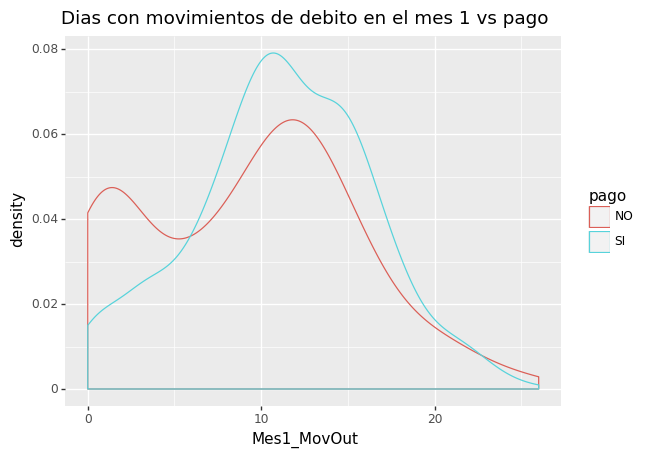

<ggplot: (8769324205281)>

In [0]:
ggplot(aes(x='Mes1_MovOut',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Dias con movimientos de debito en el mes 1 vs pago')




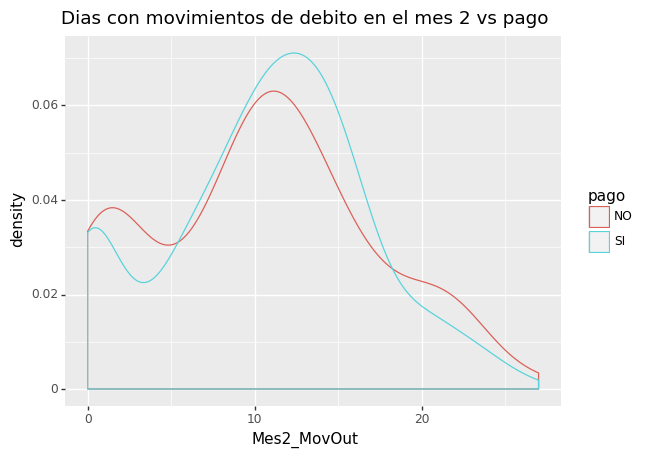

<ggplot: (8769324047038)>

In [0]:
ggplot(aes(x='Mes2_MovOut',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Dias con movimientos de debito en el mes 2 vs pago')


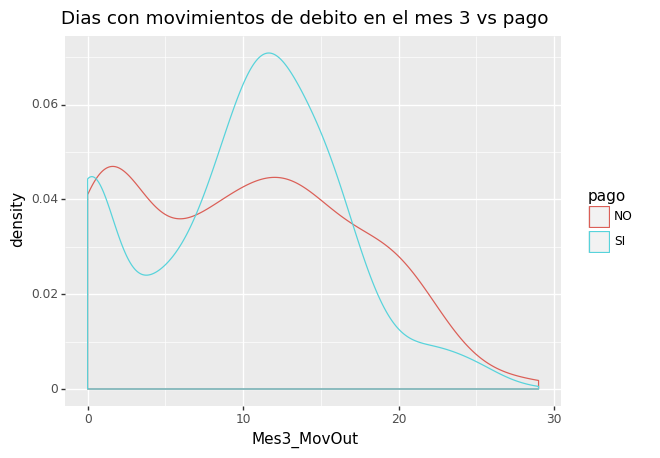

<ggplot: (-9223363267530790477)>

In [0]:
ggplot(aes(x='Mes3_MovOut',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Dias con movimientos de debito en el mes 3 vs pago')

Por otro lado, 

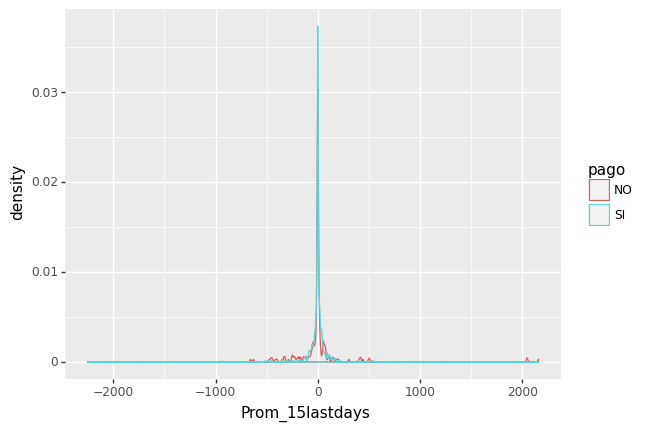

<ggplot: (-9223363250522395683)>

In [0]:
ggplot(aes(x='Prom_15lastdays',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Suma de movimientos de los ultimos 15 días vs pago')

Por ultimo se evidencia la diferencia entre los monto totales movidos por todos los clientes en función del pago y no pago, hay mas clientes que su resumen de movimientos de 90 días es 0 y hay mas clientes con resumen posotivo que no han pagado su credito.

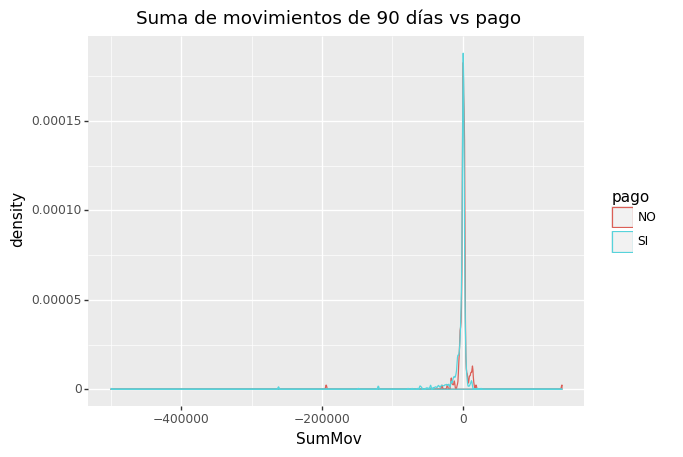

<ggplot: (8769323992205)>

In [0]:
ggplot(aes(x='SumMov',color='pago'),data=DatosFinal)+\
geom_density()+ggtitle('Suma de movimientos de 90 días vs pago')

### Analicemos los créditos otorgados por mes
Podemos observar que la actividad de otorgamiento tiene mayor magnitud entre julio y septiembre

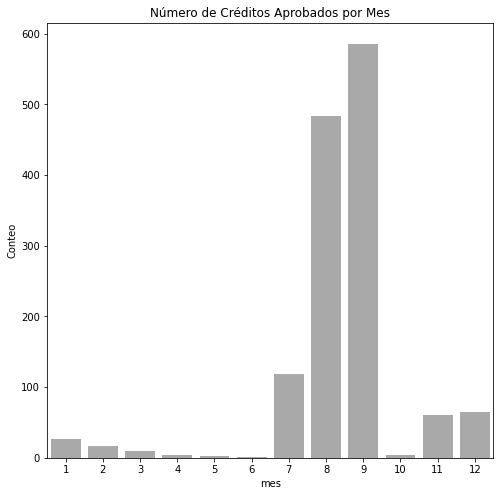

In [0]:
dataux=DatosFinal
dataux['mes']=DatosFinal.fecha.dt.month
dataux['dayweek']=DatosFinal.fecha.dt.dayofweek

ax,fig=plt.subplots(figsize=(8,8))
ax=sns.countplot(x='mes',data=dataux,color="darkgray")
ax.set_title("Número de Créditos Aprobados por Mes");
ax.set_ylabel("Conteo");

### Habrá diferencias en el comportamiento de los créditos otorgados por mes o por día?
No se observan mayores diferencias al analizar la hora del otorgamiento del crédito ni día del mes

In [0]:
def highlight(val):
  return ['background-color: red' if a>0.7 else '' for a in val] 

#por hora de aprobación
ct=pd.crosstab(DatosFinal.fecha.dt.hour,DatosFinal.pago_m,normalize="index").transpose()
ct.style.apply(highlight)

fecha,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
pago_m,,,,,,,,,,,,,,,,,,,,,,,,
0,0.862069,0.859649,0.820513,0.782609,0.826087,0.805556,0.909091,0.736842,0.956522,0.833333,0.828571,0.812500,0.567901,0.855263,0.857143,0.895833,0.793478,0.902778,0.756410,0.898305,0.842857,0.895522,0.929412,0.826923
1,0.137931,0.140351,0.179487,0.217391,0.173913,0.194444,0.090909,0.263158,0.043478,0.166667,0.171429,0.187500,0.432099,0.144737,0.142857,0.104167,0.206522,0.097222,0.243590,0.101695,0.157143,0.104478,0.070588,0.173077


In [0]:
##por día del mes
ct=pd.crosstab(DatosFinal.fecha.dt.day,DatosFinal.pago_m,normalize="index").transpose()
ct.style.apply(highlight)

fecha,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
pago_m,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.791667,0.833333,0.904762,0.875000,0.918033,0.788889,0.800000,0.852941,0.863636,0.854839,0.844444,0.901639,0.887324,0.866667,0.750000,0.838710,0.941176,0.888889,0.506329,0.857143,0.818182,0.833333,0.807692,0.941176,0.823529,0.873016,0.847458,0.871795,0.744681,0.888889,0.894737
1,0.208333,0.166667,0.095238,0.125000,0.081967,0.211111,0.200000,0.147059,0.136364,0.145161,0.155556,0.098361,0.112676,0.133333,0.250000,0.161290,0.058824,0.111111,0.493671,0.142857,0.181818,0.166667,0.192308,0.058824,0.176471,0.126984,0.152542,0.128205,0.255319,0.111111,0.105263


In [0]:
#por mes de aprobación
#parece que las personas que obtuvieron prestamos de abril a mayo, o las que lo hicieorn en noviembre, no pagan sus obligaciones
ct=pd.crosstab(DatosFinal.fecha.dt.month,DatosFinal.pago_m,normalize="index").transpose()
ct.style.apply(highlight)

fecha,1,2,3,4,5,6,7,8,9,10,11,12
pago_m,,,,,,,,,,,,
0,0.407407,0.937500,1.000000,0.000000,0.000000,0.000000,0.840336,0.838843,0.918089,0.500000,0.316667,0.784615
1,0.592593,0.062500,0.000000,1.000000,1.000000,1.000000,0.159664,0.161157,0.081911,0.500000,0.683333,0.215385


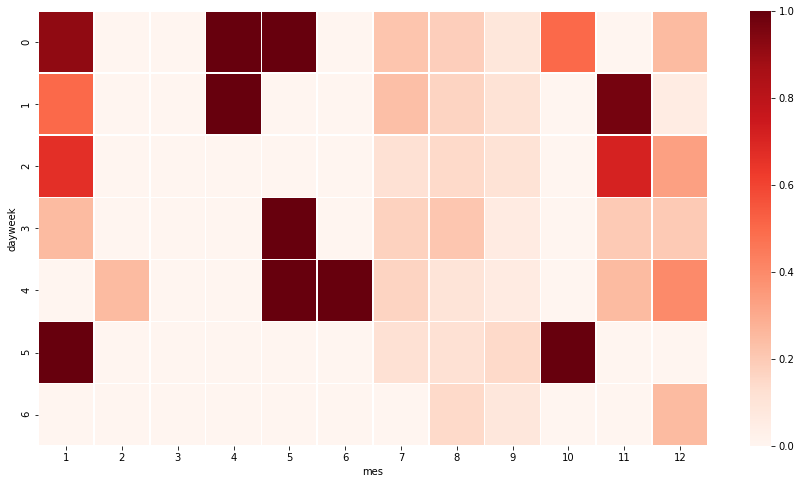

In [0]:
# vimos que existen meses en los que las personas no cumplieron con sus obligaciones. Sin embargo  veamos si este comportamiento
# puede desagregarse por día de la semana en que fue aprobado.

ct=pd.pivot_table(dataux, values='pago_m', index=['mes'],
                    columns=['dayweek'], aggfunc=np.mean).fillna(0).transpose()
import matplotlib.pyplot as plt

ax,fig=plt.subplots(figsize=(15,8))
ax=sns.heatmap(ct,cmap='Reds',linewidths=.5)

Como se creo una variable la cual categoriza el monto prestado, para la implementación del modelo es necesario codificar esta haciendo uso de la función Label Encoder de scikit learn.

In [13]:
## Codificar monto de préstamo
le=LabelEncoder()
montocat_enc=le.fit_transform(DatosFinal.MontoCat)
DatosFinal.loc[:,'MontoCat']=montocat_enc

print("Nuevas clases transformadas:\n")

[print(j[0],":",j[1]) for j in zip(le.classes_,np.unique(montocat_enc))];


Nuevas clases transformadas:

5000-10000 : 0
Mas de 10000 : 1
Menos de 5000 : 2


In [0]:
## Estandarización

In [14]:
datamodel=DatosFinal.drop(columns=['ID','pago','fecha'])
datamodel.head()


,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6,dia_7,dia_8,dia_9,dia_10,dia_11,dia_12,dia_13,dia_14,dia_15,dia_16,dia_17,dia_18,dia_19,dia_20,dia_21,dia_22,dia_23,dia_24,dia_25,dia_26,dia_27,dia_28,dia_29,dia_30,dia_31,dia_32,dia_33,dia_34,dia_35,dia_36,dia_37,dia_38,dia_39,dia_40,...,dia_70,dia_71,dia_72,dia_73,dia_74,dia_75,dia_76,dia_77,dia_78,dia_79,dia_80,dia_81,dia_82,dia_83,dia_84,dia_85,dia_86,dia_87,dia_88,dia_89,dia_90,monto,TotalMovMes1,TotalMovMes2,TotalMovMes3,Mes1_NoMov,Mes1_MovInt,Mes1_MovOut,Mes2_NoMov,Mes2_MovInt,Mes2_MovOut,Mes3_NoMov,Mes3_MovInt,Mes3_MovOut,Prom_15lastdays,SumMov,PromCliente,StdCliente,pago_m,MontoCat
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,-3500.00,0.00,...,0.00,0.0,0.0,0.0,0.0,-30.0,0.0,0.0,-102.00,0.0,0.0,0.00,0.00,0.0,-488.43,0.0,0.0,0.0,0.0,-20.0,-5743.11,150.0,-30.00,-3530.00,-6383.54,29,0,1,28,0,2,25,0,5,-398.971250,-9943.54,-110.483778,706.206677,1,2
1,20323.83,0.00,0.00,1149.58,-807.37,1240.97,1189.47,-11766.97,0.00,0.00,-277.23,1911.71,-3333.63,1351.12,-994.11,0.00,0.00,-2584.20,1490.1,1497.91,909.02,-2552.57,0.00,0.00,1369.02,-2527.99,1349.96,-2708.84,-948.15,0.00,0.00,1751.82,1523.25,2105.0,1785.60,526.27,0.00,0.00,299.15,496.21,...,-3220.97,1509.8,0.0,0.0,-1490.2,1509.8,0.0,0.0,-3034.03,0.0,0.0,1323.34,1323.34,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,100.0,-15042.20,14736.95,-10850.84,9,11,10,10,15,5,16,8,6,70.153125,9167.74,101.863778,2908.541165,1,2
2,0.00,0.00,-7.15,-7.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-150.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-30.0,0.0,0.00,100.0,-194.30,-3530.00,-30.00,27,0,3,27,0,3,29,0,1,-1.875000,-3754.30,-41.714444,369.005553,1,2
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,-40.34,-138.75,0.00,0.00,0.00,0.00,-7.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-7.0,0.0,0.00,100.0,-186.09,-7.00,-7.00,28,0,2,28,0,2,29,0,1,-0.437500,-200.09,-2.223222,15.206826,1,2
4,17.02,188.69,-62.19,288.53,0.00,0.00,-266.58,-6.97,103.49,-41.82,-831.44,0.00,0.00,288.96,87.07,63.04,-630.05,960.54,0.0,0.00,32.29,14.70,-365.65,-261.43,18.39,0.00,0.00,304.50,212.35,27.61,-310.73,524.48,0.00,0.0,-230.03,6.25,84.03,-115.45,395.57,0.00,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,900.0,-186.70,752.36,0.00,8,14,8,20,6,4,30,0,0,0.000000,582.68,6.474222,191.563784,1,2


## Ajuste de Modelos 



### Generación test y training set (70% train, 30% test)
Con el proposito de implementar el modelo es necesario realiar la partición de los datos,  ya que con una parte se entrena el modelo y con otra parte se prueba, esta partición se hace estratificada en función de la variables PAGO.

In [21]:
datamodel.drop(columns=['pago_m'])

,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6,dia_7,dia_8,dia_9,dia_10,dia_11,dia_12,dia_13,dia_14,dia_15,dia_16,dia_17,dia_18,dia_19,dia_20,dia_21,dia_22,dia_23,dia_24,dia_25,dia_26,dia_27,dia_28,dia_29,dia_30,dia_31,dia_32,dia_33,dia_34,dia_35,dia_36,dia_37,dia_38,dia_39,dia_40,...,dia_69,dia_70,dia_71,dia_72,dia_73,dia_74,dia_75,dia_76,dia_77,dia_78,dia_79,dia_80,dia_81,dia_82,dia_83,dia_84,dia_85,dia_86,dia_87,dia_88,dia_89,dia_90,monto,TotalMovMes1,TotalMovMes2,TotalMovMes3,Mes1_NoMov,Mes1_MovInt,Mes1_MovOut,Mes2_NoMov,Mes2_MovInt,Mes2_MovOut,Mes3_NoMov,Mes3_MovInt,Mes3_MovOut,Prom_15lastdays,SumMov,PromCliente,StdCliente,MontoCat
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-3500.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,-102.00,0.00,0.00,0.00,0.00,0.00,-488.43,0.00,0.00,0.00,0.00,-20.00,-5743.11,150.0,-30.00,-3530.00,-6383.54,29,0,1,28,0,2,25,0,5,-398.971250,-9943.54,-110.483778,706.206677,2
1,20323.83,0.00,0.00,1149.58,-807.37,1240.97,1189.47,-11766.97,0.00,0.00,-277.23,1911.71,-3333.63,1351.12,-994.11,0.00,0.00,-2584.20,1490.10,1497.91,909.02,-2552.57,0.00,0.00,1369.02,-2527.99,1349.96,-2708.84,-948.15,0.00,0.00,1751.82,1523.25,2105.00,1785.60,526.27,0.00,0.00,299.15,496.21,...,1303.49,-3220.97,1509.80,0.00,0.00,-1490.20,1509.80,0.00,0.00,-3034.03,0.00,0.00,1323.34,1323.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.0,-15042.20,14736.95,-10850.84,9,11,10,10,15,5,16,8,6,70.153125,9167.74,101.863778,2908.541165,2
2,0.00,0.00,-7.15,-7.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-150.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,100.0,-194.30,-3530.00,-30.00,27,0,3,27,0,3,29,0,1,-1.875000,-3754.30,-41.714444,369.005553,2
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-40.34,-138.75,0.00,0.00,0.00,0.00,-7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-7.00,0.00,0.00,100.0,-186.09,-7.00,-7.00,28,0,2,28,0,2,29,0,1,-0.437500,-200.09,-2.223222,15.206826,2
4,17.02,188.69,-62.19,288.53,0.00,0.00,-266.58,-6.97,103.49,-41.82,-831.44,0.00,0.00,288.96,87.07,63.04,-630.05,960.54,0.00,0.00,32.29,14.70,-365.65,-261.43,18.39,0.00,0.00,304.50,212.35,27.61,-310.73,524.48,0.00,0.00,-230.03,6.25,84.03,-115.45,395.57,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,900.0,-186.70,752.36,0.00,8,14,8,20,6,4,30,0,0,0.000000,582.68,6.474222,191.563784,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,-698.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11000.0,0.00,0.00,0.00,29,0,1,30,0,0,30,0,0,0.000000,-698.26,-7.758444,73.603067,1
1374,220.68,-2447.71,16011.54,0.00,0.00,47.50,1045.44,-672.48,-2977.94,551.10,0.00,0.00,1468.05,-985.94,-1074.29,-2471.11,2262.99,0.00,-292.02,13849.56,-2546.96,-3815.19,1158.19,0.00,0.00,-105.48,-2469.76,386.52,-7321.68,-2676.45,1324.34,0.00,-537.97,-3199.25,952.68,-5007.01,-1323.52,425.84,0.00,-63.00,...,-5866.84,7390.40,-916.26,-1369.65,5244.15,0.00,-391.79,-3716.67,464.79,-5

In [0]:

X_train, X_test, y_train, y_test = train_test_split(
    datamodel.drop(columns=['pago_m']).values,  # matriz con las variables predictivas
    datamodel['pago_m'].values, # array con los valores de la variable objetivo
    test_size=0.3,  # proporción a dejar en el test set
    random_state=123, # para controlar la semilla aleatoria
    stratify=datamodel['pago_m'].values) # indica la variable de estratificación estratificación de la muestra


### Oversampling

Debido a que existen desbalanceos en la variable objetivo, se procederá a sobremuestrear la categoría de menores registros, de forma que existan al menos un ratio de 0.4 en la clase menos frecuente sobre la más frecuente. Actualmente ese ratio es alrededor de 0.19


In [27]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
rus = RandomOverSampler(random_state=123,sampling_strategy=0.5)
X_resampled, y_resampled = rus.fit_resample(X_train,y_train)
###la data es devuelta en forma secuencial: una clase tras otra, por lo que debemos aleatorizarla
datamod=pd.DataFrame(np.column_stack([X_resampled,y_resampled])).sample(frac=1).values
print("Valores balanceados : ", Counter(datamod[:,-1]));

nrow,ncol=datamod.shape
X_resampled=datamod[:,0:(ncol-1)]
y_resampled=datamod[:,-1]
y_train=y_resampled

Valores balanceados :  Counter({0.0: 805, 1.0: 402})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [25]:
print(X_resampled.shape)
print(X_test.shape)

(1207, 108)
(414, 108)


#### Oversampling Adasyn
Una alternativa para combatir el problema de datos desbalanceados en la variable objetivo es remuestrear registros de la clase menos frecuente. Mediante Adasyn se crean puntos sintéticos de esta clase usando técnicas de interpolación entre un número de instancias de la clase. Sin embargo, dado el contexto de dependencia de las variables de entrada, no se utiliza en este trabajo.

### Estandarización de los valores observados por día
A continuación construimos una función para estandarizar los comportamientos de cada cliente según sus transacciones en los últimos 90 días.

In [0]:
DataX_train=X_resampled
DataX_test=X_test

def std_day(x):
  ##"INPUT AS A PD. DATAFRAME
  daily_data_Train=x[:,0:90].T
  scaled_features =StandardScaler()
  daily_dataSTD_Train=scaled_features.fit_transform(daily_data_Train).T
  CreateVars_Train=x[:,90:107]
  CreateVarSTD_Train=scaled_features.fit_transform(CreateVars_Train)
  datamod=np.hstack([daily_dataSTD_Train, CreateVarSTD_Train])
  return (datamod)

DataX_train=std_day(DataX_train)
DataX_test=std_day(DataX_test)

In [29]:
DataX_train.shape
#DataX_train.shape

(1207, 107)

### Metricas


Teniendo en cuenta los requerimientos solicitados se crea una función en la cual se brinda información del comportamiento de los modelos implementados, en ella se observa, el Accuracy, Kappa y el F1 Score.

In [0]:
## medir el desempeño del clasificador
from sklearn.metrics import precision_score,recall_score

def metrics(real,pred):
  kappa=cohen_kappa_score(real,pred)
  acc=accuracy_score(real,pred)
  f1=f1_score(real,pred)
  prec=precision_score(real,pred)
  recall=recall_score(real,pred)

  print (f" Accuracy:{acc:.4f} \n Precision: {prec:.4f} \n Recall: {recall:.4f} \n Kappa: {kappa:.4f} \n F1-Score: {f1:.4f} ")



## Regresion Logistica 




In [31]:
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([
  ('clf', LogisticRegression(penalty='l2',class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))])

params = {'clf__C':[0.001,0.01,0.1,1,10]}
scoring={'kappa':make_scorer(cohen_kappa_score),'accuracy':'accuracy'}
grid= GridSearchCV(pipeline, params,scoring=scoring,refit='kappa')
grid.fit(DataX_train, y_train)
pred_lass=grid.predict(DataX_test)
pred_lass_train=grid.predict(DataX_train)
print(grid.best_params_)

metrics(y_test,pred_lass)

{'clf__C': 10}
 Accuracy:0.6860 
 Precision: 0.2615 
 Recall: 0.5000 
 Kappa: 0.1629 
 F1-Score: 0.3434 


### LDA

In [32]:
## definir pasos para estandarizar los datos y entrenar el LDA
steps = [('LDA', LinearDiscriminantAnalysis())]
pipelineLDA = Pipeline(steps)
##correr el pipeline
pipelineLDA.get_params().keys()
pipelineLDA.fit(DataX_train, y_train)
pred_lda_train=pipelineLDA.predict(DataX_train)
pred_lda=pipelineLDA.predict(DataX_test)
prob_lda_train=pipelineLDA.predict_proba(DataX_train)
prob_lda_test=pipelineLDA.predict_proba(DataX_test)

metrics(y_test,pred_lda)





 Accuracy:0.7874 
 Precision: 0.3571 
 Recall: 0.3676 
 Kappa: 0.2348 
 F1-Score: 0.3623 


### QDA

In [33]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
steps = [('QDA', QuadraticDiscriminantAnalysis())]
pipelineQDA = Pipeline(steps)
##correr el pipeline
pipelineQDA.get_params().keys()
pipelineQDA.fit(DataX_train, y_train)
pred_qda=pipelineQDA.predict(DataX_test)
pred_qda_train=pipelineQDA.predict(DataX_train)
metrics(y_test,pred_qda)



 Accuracy:0.6763 
 Precision: 0.0658 
 Recall: 0.0735 
 Kappa: -0.1257 
 F1-Score: 0.0694 


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### SVM

SVM - Kernel Lineal

In [34]:
scoring={'kappa':make_scorer(cohen_kappa_score),'accuracy':'accuracy'}
steps = [("SVM_linear", SVC(kernel="linear",probability=True))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=scoring,n_jobs=-1,refit='kappa')
grid1.fit(DataX_train, y_train)
print("score = %3.4f" %(grid1.score(DataX_test,y_test)))
print(grid1.best_params_)
y_svm_lin=grid1.predict(DataX_test)
y_svm_lin_train=grid1.predict(DataX_train)
prob_svm_lin=grid1.predict_proba(DataX_test)
metrics(y_test,y_svm_lin)



score = 0.1998
{'SVM_linear__C': 1}
 Accuracy:0.7440 
 Precision: 0.3021 
 Recall: 0.4265 
 Kappa: 0.1998 
 F1-Score: 0.3537 


SVM - Kernel RBF

In [35]:
steps = [("SVM_rbf", SVC(kernel="rbf",probability=True))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10], 'SVM_rbf__gamma':[0.05,0.01, 1, 5]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=scoring,n_jobs=-1,refit='kappa')
grid1.fit(DataX_train, y_train)
print("score = %3.4f" %(grid1.score(DataX_test,y_test)))
print(grid1.best_params_)
y_svm_rbf=grid1.predict(DataX_test)
y_svm_rbf_train=grid1.predict(DataX_train)
prob_svm_rbf_prob=grid1.predict_proba(DataX_train)
metrics(y_test,y_svm_rbf)
prob_svm_rbf=grid1.predict_proba(DataX_test)


score = 0.2439
{'SVM_rbf__C': 1, 'SVM_rbf__gamma': 0.05}
 Accuracy:0.8623 
 Precision: 1.0000 
 Recall: 0.1618 
 Kappa: 0.2439 
 F1-Score: 0.2785 


SVM - Kernel Sigmoid

In [37]:
steps = [("SVM_sigmoid", SVC(kernel="sigmoid",probability=True))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=scoring,n_jobs=-1,refit='kappa')
grid1.fit(DataX_train, y_train)
print("score = %3.4f" %(grid1.score(DataX_test,y_test)))
y_svm_sig=grid1.predict(DataX_test)
y_svm_sig_train=grid1.predict(DataX_train)
print(grid1.best_params_)
prob_svm_sig=grid1.predict_proba(DataX_test)
metrics(y_test,y_svm_sig)


score = 0.1872
{'SVM_sigmoid__C': 0.1, 'SVM_sigmoid__gamma': 0.01}
 Accuracy:0.8454 
 Precision: 0.6250 
 Recall: 0.1471 
 Kappa: 0.1872 
 F1-Score: 0.2381 


Ahora veamos si una descomposición en Componentes Principales de los valores,ayuda en la predicción: 

In [38]:
from sklearn.decomposition import PCA

steps = [('PCA', PCA()), ("SVM_linear", SVC(kernel="linear",probability=True))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10],'PCA__n_components':[None,10, 15, 20]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=scoring,n_jobs=-1,refit='kappa')
grid1.fit(DataX_train, y_train)
print("score = %3.4f" %(grid1.score(DataX_test,y_test)))
print(grid1.best_params_)
y_svm_lin_pca=grid1.predict(DataX_test)
y_svm_lin_pca_train=grid1.predict(DataX_train)
prob_lin_sig_pca=grid1.predict_proba(DataX_train)
prob_lin_sig_pca_test=grid1.predict_proba(DataX_test)
metrics(y_test,y_svm_lin_pca)

score = 0.2177
{'PCA__n_components': None, 'SVM_linear__C': 10}
 Accuracy:0.7560 
 Precision: 0.3187 
 Recall: 0.4265 
 Kappa: 0.2177 
 F1-Score: 0.3648 


In [39]:
steps = [('PCA', PCA()),("SVM_rbf", SVC(kernel="rbf",probability=True))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10], 'SVM_rbf__gamma':[0.05,0.01, 1, 5], 'PCA__n_components':[None,10, 15, 20]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=scoring,n_jobs=-1,refit='kappa')
grid1.fit(DataX_train, y_train)
print("score = %3.4f" %(grid1.score(DataX_test,y_test)))
print(grid1.best_params_)
y_svm_rbf_pca=grid1.predict(DataX_test)
y_svm_rbf_pca_train=grid1.predict(DataX_train)
prob_svm_rbf_pca=grid1.predict_proba(DataX_train)
prob_svm_rbf_pca_test=grid1.predict_proba(DataX_test)
metrics(y_test,y_svm_rbf_pca)



score = 0.2439
{'PCA__n_components': None, 'SVM_rbf__C': 1, 'SVM_rbf__gamma': 0.05}
 Accuracy:0.8623 
 Precision: 1.0000 
 Recall: 0.1618 
 Kappa: 0.2439 
 F1-Score: 0.2785 


**Kernel** - SVM Sigmoide con Reducción de Dimensionalidad

In [40]:
from sklearn.decomposition import PCA
metrica='accuracy'
steps = [('PCA', PCA()),("SVM_sigmoid", SVC(kernel="sigmoid",probability=True))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5], 'PCA__n_components':[None,10, 15, 20]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=scoring,n_jobs=-1,refit='kappa')
grid1.fit(DataX_train, y_train)
print("score = %3.4f" %(grid1.score(DataX_test,y_test)))
print(grid1.best_params_)
y_svm_sig_pca=grid1.predict(DataX_test)
y_svm_sig_pca_train=grid1.predict(DataX_train)
prob_svm_sig_pca=grid1.predict_proba(DataX_test)
metrics(y_test,y_svm_sig_pca)


score = 0.2277
{'PCA__n_components': 10, 'SVM_sigmoid__C': 1, 'SVM_sigmoid__gamma': 0.01}
 Accuracy:0.7729 
 Precision: 0.3375 
 Recall: 0.3971 
 Kappa: 0.2277 
 F1-Score: 0.3649 


SVM usando LDA como reducción de dimensionalidad

In [41]:
steps = [('LDA', LinearDiscriminantAnalysis()), ("SVM_linear", SVC(kernel="linear",probability=True))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=scoring,n_jobs=-1,refit='kappa')
grid1.fit(DataX_train, y_train)
print("score = %3.4f" %(grid1.score(DataX_test,y_test)))
print(grid1.best_params_)
y_svm_lin_pca=grid1.predict(DataX_test)
y_svm_lin_pca_train=grid1.predict(DataX_train)
prob_lin_sig_pca=grid1.predict_proba(DataX_train)
prob_lin_sig_pca_test=grid1.predict_proba(DataX_test)
metrics(y_test,y_svm_lin_pca)

score = 0.2391
{'SVM_linear__C': 0.1}
 Accuracy:0.7899 
 Precision: 0.3623 
 Recall: 0.3676 
 Kappa: 0.2391 
 F1-Score: 0.3650 


In [42]:
metrica='accuracy'
steps = [('LDA', LinearDiscriminantAnalysis()),("SVM_rbf", SVC(kernel="rbf",probability=True))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10], 'SVM_rbf__gamma':[0.05,0.01, 1, 5],'LDA__n_components':[None, 1]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=scoring,n_jobs=-1,refit='kappa')
grid1.fit(DataX_train, y_train)
print("score = %3.4f" %(grid1.score(DataX_test,y_test)))
print(grid1.best_params_)
y_svm_rbf_lda=grid1.predict(DataX_test)
y_svm_rbf_lda_train=grid1.predict(DataX_train)
prob_svm_rbf_lda=grid1.predict_proba(DataX_train)
prob_svm_rbf_lda_test=grid1.predict_proba(DataX_test)
metrics(y_test,y_svm_rbf_lda)

score = 0.1938
{'LDA__n_components': None, 'SVM_rbf__C': 1, 'SVM_rbf__gamma': 5}
 Accuracy:0.7512 
 Precision: 0.3034 
 Recall: 0.3971 
 Kappa: 0.1938 
 F1-Score: 0.3439 


SVM usando LDA como reducción de dimensionalidad

In [43]:
metrica='accuracy'
steps = [('LDA', LinearDiscriminantAnalysis()),("SVM_sigmoid", SVC(kernel="sigmoid",probability=True))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5],'LDA__n_components':[None, 1]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=scoring,n_jobs=-1,refit='kappa')
grid1.fit(DataX_train, y_train)
print("score = %3.4f" %(grid1.score(DataX_test,y_test)))
print(grid1.best_params_)
y_svm_rbf_lda=grid1.predict(DataX_test)
y_svm_rbf_lda_train=grid1.predict(DataX_train)
prob_svm_rbf_lda=grid1.predict_proba(DataX_train)
prob_svm_rbf_lda_test=grid1.predict_proba(DataX_test)
metrics(y_test,y_svm_rbf_lda)

score = 0.1371
{'LDA__n_components': None, 'SVM_sigmoid__C': 0.01, 'SVM_sigmoid__gamma': 1}
 Accuracy:0.6763 
 Precision: 0.2462 
 Recall: 0.4706 
 Kappa: 0.1371 
 F1-Score: 0.3232 


### RIDGE Y LASSO: ELASTIC NET

In [44]:
### Clasificador con regularización l1 y l2 por elastic net: regresión logística y SVM
steps = [('ELNET', SGDClassifier(penalty="elasticnet",early_stopping=True,validation_fraction=0.1))]
pipeline = Pipeline(steps)
parametros={'ELNET__loss':['log'],
            'ELNET__l1_ratio':np.linspace(0,1,11)}
grid1=GridSearchCV(pipeline,param_grid=parametros,cv=5,n_jobs=-1,scoring=scoring,refit='kappa')
grid1.fit(DataX_train,y_train)
pred_enet=grid1.predict(DataX_test)
pred_enet_train=grid1.predict(DataX_train)
metrics(y_test,pred_enet)
prob_enet=grid1.predict_proba(DataX_train)
prob_enet_test=grid1.predict_proba(DataX_test)


 Accuracy:0.7222 
 Precision: 0.2883 
 Recall: 0.4706 
 Kappa: 0.1932 
 F1-Score: 0.3575 


In [45]:
#revisar cuál fue el modelo que tuvo el mejor comportamiento de los ajustados en ElasticNet
grid1.best_estimator_.get_params()['ELNET']

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.5, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### REDES NEURONALES

A partir de los últimos 90 días del comportamiento, analizaremos la probabilidad de que una persona no pague sus obligaciones, a través del uso de una red neuronal convencional (MLP) y una recurrente (LSTM).

In [46]:
from sklearn.neural_network import MLPClassifier
from math import sqrt

np.random.seed(1234)
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=1000)
mlp.fit(DataX_train[:,0:90],y_train)

y_pred = mlp.predict(DataX_test[:,0:90])
y_pred_train = mlp.predict(DataX_train[:,0:90])
metrics(y_test,y_pred)
proba_mlp=mlp.predict_proba(DataX_train[:,0:90])
proba_mlp_test=mlp.predict_proba(DataX_test[:,0:90])


 Accuracy:0.8261 
 Precision: 0.4474 
 Recall: 0.2500 
 Kappa: 0.2301 
 F1-Score: 0.3208 


Ahora veamos cómo se comporta una Red Neuronal Recurrente, para ello debemos redimiensionar la base de entrenamiento, de forma que el input tenga 3 dimensiones. En el caso de la variable de respuesta, debemos tener una matriz con número de columnas igual al número de clases, con valores binarios en donde aplique cada categoría.

In [48]:
from tensorflow.keras.utils import to_categorical

sc=StandardScaler()
X_train2=sc.fit_transform(DataX_train[:,0:90])
#X_train2=DataX_train[:,0:90]
X_test2=sc.transform(DataX_test[:,0:90])
#X_test2=DataX_test[:,0:90]
# print("Dimensión original de la base: ",X_train2.shape)

##Redimensionar para que la red neuronal tome valores de entrenamiento en dimensión (90 días, 1 registro)
X_train2=np.reshape(X_train2,(-1,90,1))
X_test2=np.reshape(X_test2,(-1,90,1))
y_train2=to_categorical(y_train,2)
y_test2=to_categorical(y_test,2)
print("Dimensión transformada de la base: ",X_train2.shape)

Dimensión transformada de la base:  (1207, 90, 1)


In [49]:
from tensorflow.keras.layers import LSTM,Dense,Conv1D,TimeDistributed,Dropout,BatchNormalization,Flatten,LeakyReLU
from tensorflow.keras.models import Sequential

mod=Sequential()
## capa convolucional que recorre cada 8 días los picos de actividad más relevantes
mod.add(Conv1D(filters=64,input_shape=(X_train2.shape[1],1),kernel_size=7,activation="relu"))
mod.add(BatchNormalization())
mod.add(LeakyReLU())
mod.add(LSTM(50,return_sequences=True))
mod.add(Dropout(0.5))
mod.add(LSTM(50,return_sequences=True))
mod.add(Dropout(0.5))
mod.add(LSTM(50,return_sequences=False))
mod.add(Dropout(0.5))
mod.add(Dense(1,activation="sigmoid"))

opt=tf.keras.optimizers.Adam(
    learning_rate=0.001,
)
cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,restore_best_weights=True)

mod.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])

mod.fit(
    X_train2,
    y_train,
    validation_data=(X_test2,y_test),
    epochs = 50,
    batch_size = 30,
    callbacks=[cb]
)

Epoch 1/50
41/41 [==============================] - 6s 157ms/step - loss: 0.6262 - accuracy: 0.6645 - val_loss: 0.5429 - val_accuracy: 0.8382
Epoch 2/50
41/41 [==============================] - 6s 136ms/step - loss: 0.5585 - accuracy: 0.7291 - val_loss: 0.4989 - val_accuracy: 0.8309
Epoch 3/50
41/41 [==============================] - 6s 137ms/step - loss: 0.5152 - accuracy: 0.7556 - val_loss: 0.4501 - val_accuracy: 0.8357
Epoch 4/50
41/41 [==============================] - 6s 136ms/step - loss: 0.4619 - accuracy: 0.7937 - val_loss: 0.4402 - val_accuracy: 0.8382
Epoch 5/50
41/41 [==============================] - 5s 134ms/step - loss: 0.4496 - accuracy: 0.8111 - val_loss: 0.4301 - val_accuracy: 0.8382
Epoch 6/50
41/41 [==============================] - 6s 135ms/step - loss: 0.4198 - accuracy: 0.8186 - val_loss: 0.4382 - val_accuracy: 0.8527
Epoch 7/50
41/41 [==============================] - 6s 138ms/step - loss: 0.3939 - accuracy: 0.8351 - val_loss: 0.4475 - val_accuracy: 0.8454
Epoch 

In [50]:
### Revisemos la estructura del modelo
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 84, 64)            512       
_________________________________________________________________
batch_normalization (BatchNo (None, 84, 64)            256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 84, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 84, 50)            23000     
_________________________________________________________________
dropout (Dropout)            (None, 84, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 84, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 84, 50)            0

In [56]:
##Predecir valores de prueba y realizar métricas
y_pred_lstm_proba=mod.predict(X_train2)
#y_pred_lstm=np.argmax(y_pred_lstm,axis=1)
y_pred_lstm_proba_test=mod.predict(X_test2)

y_pred_lstm=np.where(y_pred_lstm_proba_test>0.5,1,0)
y_pred_lstm_train=np.where(y_pred_lstm_proba>0.5,1,0)

metrics(y_test,y_pred_lstm)

 Accuracy:0.9058 
 Precision: 0.7302 
 Recall: 0.6765 
 Kappa: 0.6464 
 F1-Score: 0.7023 


## Analicemos la curva ROC

El valor de corte entre 0.4 y 0.5 parece ser un valor adecuado bajo el trade-off entre la sensibilidad y especificidad 



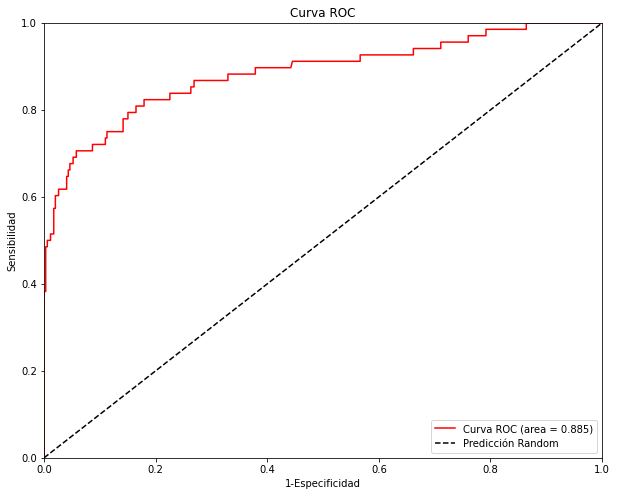

In [57]:
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lstm_proba_test)
roc_auc = roc_auc_score(y_test, y_pred_lstm_proba_test)

# Plot ROC curve

ax,fig=plt.subplots(figsize=(10,8))
ax=plt.plot(fpr, tpr, label='Curva ROC (area = %0.3f)' % roc_auc, color="red");
ax=plt.plot([0, 1], [0, 1], '--',color="black",label="Predicción Random") 
ax=plt.xlim([0.0, 1.0])
ax=plt.ylim([0.0, 1.0])
ax=plt.xlabel('1-Especificidad')
ax=plt.ylabel('Sensibilidad')
ax=plt.title('Curva ROC')
ax=plt.legend(loc="lower right")



## Autoencoder
Ahora probamos construyendo una red neuronal que reduzca la dimensionalidad de los datos, para finalmente representarlos de forma compacta en una menor dimensión. Esta nueva representación será el input de otra parte de la red neuronal e intentará detectar patrones que permitan establecer si el cliente pagará o no su crédito.


enc_dec=model

In [61]:
nrow,ncol=DataX_train.shape
print(ncol)

DataX_train.shape

107


(1207, 107)

In [62]:
X_train_enc=DataX_train.reshape((-1,ncol,1))
X_test_enc=DataX_test.reshape((-1,ncol,1))

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l2,l1

##
encoder_input = Input(shape=(ncol,1), name='encoder_input')
conv1=Conv1D(filters=32,kernel_size=15)(encoder_input)
relu_cv1=LeakyReLU()(conv1)
bn_cv1=BatchNormalization()(relu_cv1)
conv2=Conv1D(filters=64,kernel_size=3)(bn_cv1)
relu_cv2=LeakyReLU()(conv2)
bn_cv2=BatchNormalization()(relu_cv2)
conv3=Conv1D(filters=32,kernel_size=3)(bn_cv2)
relu_cv3=LeakyReLU()(conv3)
bn_cv3=BatchNormalization()(relu_cv3)
flatt_cv3=Flatten()(bn_cv3)
dense1=Dense(2)(flatt_cv3)
relu_dense=LeakyReLU()(dense1)
dense_d1=Dense(100,activation="relu")(relu_dense)
dropdense=Dropout(0.6)(dense_d1)
dense2=Dense(1,activation="sigmoid")(dropdense)
autoencod = Model([encoder_input], [dense2],name="autoencoder")

##fit encoder & decoder 

encoder=Model(encoder_input,relu_dense,name="encoder")
decoder_layer=autoencod.layers[-1] 
encoded_input = Input(shape=(100),name="decoder_input")

decoder= Model(encoded_input,decoder_layer(encoded_input),name="decoder")


print(autoencod.summary())
print(encoder.summary())
print(decoder.summary())

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 107, 1)]          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 93, 32)            512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 93, 32)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 93, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 91, 64)            6208      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 91, 64)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 91, 64)            

In [63]:
cb2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,restore_best_weights=True) #set the best weights found at scoring on validation set

autoencod.compile(
    metrics=['accuracy'],
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005,decay=1e-04)  
)

history = autoencod.fit(X_train_enc, y_train, batch_size=20, epochs=50,callbacks=[cb2],validation_data=(X_test_enc,y_test))


Epoch 1/50
61/61 [==============================] - 1s 18ms/step - loss: 0.6686 - accuracy: 0.6346 - val_loss: 0.5337 - val_accuracy: 0.7995
Epoch 2/50
61/61 [==============================] - 1s 15ms/step - loss: 0.5249 - accuracy: 0.7630 - val_loss: 0.4341 - val_accuracy: 0.8285
Epoch 3/50
61/61 [==============================] - 1s 15ms/step - loss: 0.4058 - accuracy: 0.8227 - val_loss: 0.4894 - val_accuracy: 0.7923
Epoch 4/50
61/61 [==============================] - 1s 15ms/step - loss: 0.3874 - accuracy: 0.8351 - val_loss: 0.4915 - val_accuracy: 0.8164
Epoch 5/50
61/61 [==============================] - 1s 15ms/step - loss: 0.3012 - accuracy: 0.8674 - val_loss: 0.6415 - val_accuracy: 0.8043
Epoch 6/50
61/61 [==============================] - 1s 15ms/step - loss: 0.3156 - accuracy: 0.8650 - val_loss: 0.6355 - val_accuracy: 0.7826
Epoch 7/50
61/61 [==============================] - 1s 15ms/step - loss: 0.2199 - accuracy: 0.9130 - val_loss: 0.8281 - val_accuracy: 0.8188
Epoch 8/50
61

In [64]:
### Cómo se desempeña el modelo que usa autoencoder para realizar la predicción?
y_autoenc_test=np.where(autoencod.predict(X_test_enc)>0.5,1,0)
metrics(y_test,y_autoenc_test)


 Accuracy:0.8285 
 Precision: 0.4615 
 Recall: 0.2647 
 Kappa: 0.2462 
 F1-Score: 0.3364 


Veamos como se desempeña el encoder para reducir dimensionalidad




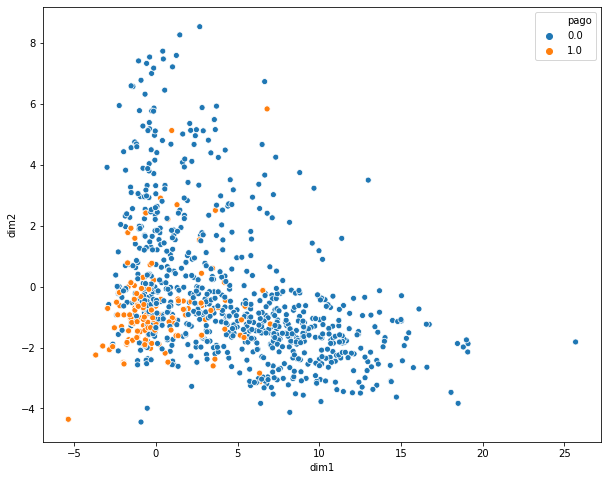

In [65]:
encod_data=pd.DataFrame(np.column_stack([encoder.predict(X_train_enc)[:,0:2],y_train]),columns=['dim1','dim2','pago'])

ax,f=plt.subplots(figsize=(10,8))
ax=sns.scatterplot(x="dim1",y="dim2",hue="pago",data=encod_data)

### STACKING: 
Vamos a utilizar los cuatro modelos más precisos para elaborar un modelo final que establezca la probabilidad de pago usando toda la información disponible. Para ello elaboramos un dataset que contiene las probabilidades de cada modelo y la variable objetivo, tanto para el training como el testing set. Posteriormente construimos un clasificador SVM con esta información.

In [0]:
data_stack_train=pd.DataFrame({'prob_lda': prob_lda_train[:,1],'prob_mlp': proba_mlp[:,1],'prob_svm': prob_svm_rbf_pca[:,1],'prob_lstm':y_pred_lstm_proba[:,0],'target':y_train})
data_stack_test=pd.DataFrame({'prob_lda': prob_lda_test[:,1],'prob_mlp': proba_mlp_test[:,1],'prob_svm': prob_svm_rbf_pca_test[:,1],'prob_lstm':y_pred_lstm_proba_test[:,0],'target':y_test})
data_stack_train.head()
###shuffle data
data_stack_train=data_stack_train.sample(frac=1)



In [68]:
metrica='accuracy'
steps = [("SVM_stack", SVC(kernel="rbf",probability=True))]
pipeline = Pipeline(steps)
parametros = {'SVM_stack__C':[0.01,0.1,1,10], 'SVM_stack__gamma':[0.05,0.01, 1, 5]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica,n_jobs=-1)
grid1.fit(data_stack_train.iloc[:,0:3], data_stack_train.iloc[:,4])
y_svm_stack=grid1.predict(data_stack_test.iloc[:,0:3])
y_svm_stack_train=grid1.predict(data_stack_train.iloc[:,0:3])
prob_svm_stack_test=grid1.predict_proba(data_stack_test.iloc[:,0:3])
metrics(data_stack_test.iloc[:,4],y_svm_stack)
#metrics(data_stack_train.iloc[:,4],y_svm_stack_train)



 Accuracy:0.8502 
 Precision: 0.6500 
 Recall: 0.1912 
 Kappa: 0.2386 
 F1-Score: 0.2955 


In [69]:
##stacking usando MLP
mlp = MLPClassifier(hidden_layer_sizes=(150,150,150), max_iter=1000)
mlp.fit(data_stack_train.iloc[:,0:3], data_stack_train.iloc[:,4])

y_mlp_stack = mlp.predict(data_stack_test.iloc[:,0:3])
y_mlp_stack_train = mlp.predict(data_stack_train.iloc[:,0:3])

proba_mlp=mlp.predict_proba(data_stack_test.iloc[:,0:3])
proba_mlp_test=mlp.predict_proba(data_stack_train.iloc[:,0:3])
metrics(data_stack_test.iloc[:,4],y_mlp_stack)

 Accuracy:0.8140 
 Precision: 0.4043 
 Recall: 0.2794 
 Kappa: 0.2266 
 F1-Score: 0.3304 


### Resumen Modelos Propuestos

A continuación se resumen las métricas de los modelos ajustados

In [70]:
NombresModelos=['Regresion Ridge','LDA','QDA','SVM Lineal','SVM RBF','SVM Sigmoid',
                'SVM Lineal PCA','SVM RBF PCA','SVM Sigmoid PCA','SVM RBF LDA',
                'Elastic Net','MLP','LSTM','Stacking']
Accuracy_Train=[accuracy_score(y_train,pred_lass_train),accuracy_score(y_train,pred_lda_train),accuracy_score(y_train,pred_qda_train),
                accuracy_score(y_train,y_svm_lin_train),accuracy_score(y_train,y_svm_rbf_train),accuracy_score(y_train,y_svm_sig_train),
                accuracy_score(y_train,y_svm_lin_pca_train),
                accuracy_score(y_train,y_svm_rbf_pca_train),accuracy_score(y_train,y_svm_sig_pca_train),
                accuracy_score(y_train,y_svm_rbf_lda_train),accuracy_score(y_train,pred_enet_train),
                accuracy_score(y_train,y_pred_train),accuracy_score(y_train,y_pred_lstm_train),accuracy_score(data_stack_train.iloc[:,4],y_svm_stack_train)]
        
Accuracy_Test=[accuracy_score(y_test,pred_lass),accuracy_score(y_test,pred_lda),accuracy_score(y_test,pred_qda),
                accuracy_score(y_test,y_svm_lin),accuracy_score(y_test,y_svm_rbf),accuracy_score(y_test,y_svm_sig),
                accuracy_score(y_test,y_svm_lin_pca),
                accuracy_score(y_test,y_svm_rbf_pca),accuracy_score(y_test,y_svm_sig_pca),
                accuracy_score(y_test,y_svm_rbf_lda),accuracy_score(y_test,pred_enet),
                accuracy_score(y_test,y_pred),accuracy_score(y_test,y_pred_lstm),accuracy_score(data_stack_test.iloc[:,4],y_svm_stack)]

Kappa_Train=[cohen_kappa_score(y_train,pred_lass_train),cohen_kappa_score(y_train,pred_lda_train),cohen_kappa_score(y_train,pred_qda_train),
                cohen_kappa_score(y_train,y_svm_lin_train),cohen_kappa_score(y_train,y_svm_rbf_train),cohen_kappa_score(y_train,y_svm_sig_train),
                cohen_kappa_score(y_train,y_svm_lin_pca_train),
                cohen_kappa_score(y_train,y_svm_rbf_pca_train),cohen_kappa_score(y_train,y_svm_sig_pca_train),
                cohen_kappa_score(y_train,y_svm_rbf_lda_train),cohen_kappa_score(y_train,pred_enet_train),
                cohen_kappa_score(y_train,y_pred_train),cohen_kappa_score(y_train,y_pred_lstm_train),cohen_kappa_score(data_stack_train.iloc[:,4],y_svm_stack_train)]

Kappa_Test=[cohen_kappa_score(y_test,pred_lass),cohen_kappa_score(y_test,pred_lda),cohen_kappa_score(y_test,pred_qda),
                cohen_kappa_score(y_test,y_svm_lin),cohen_kappa_score(y_test,y_svm_rbf),cohen_kappa_score(y_test,y_svm_sig),
                cohen_kappa_score(y_test,y_svm_lin_pca),
                cohen_kappa_score(y_test,y_svm_rbf_pca),cohen_kappa_score(y_test,y_svm_sig_pca),
                cohen_kappa_score(y_test,y_svm_rbf_lda),cohen_kappa_score(y_test,pred_enet),
                cohen_kappa_score(y_test,y_pred),cohen_kappa_score(y_test,y_pred_lstm),cohen_kappa_score(data_stack_test.iloc[:,4],y_svm_stack)]



Tabla={'NombresModelos':NombresModelos,'Accuracy Train':Accuracy_Train,'Accuracy Test':Accuracy_Test,
             'Kappa Train':Kappa_Train,'Kappa Test':Kappa_Test}
pd.DataFrame(Tabla)


,NombresModelos,Accuracy Train,Accuracy Test,Kappa Train,Kappa Test
0,Regresion Ridge,0.781276,0.685990,0.531583,0.162882
1,LDA,0.787075,0.787440,0.491261,0.234815
2,QDA,0.975145,0.676329,0.943204,-0.125731
3,SVM Lineal,0.816073,0.743961,0.569368,0.199781
4,SVM RBF,0.999171,0.862319,0.998134,0.243896
5,SVM Sigmoid,0.724938,0.845411,0.226790,0.187239
6,SVM Lineal PCA,0.780447,0.789855,0.471935,0.239067
7,SVM RBF PCA,0.999171,0.862319,0.998134,0.243896
8,SVM Sigmoid PCA,0.682684,0.772947,0.226503,0.227735
9,SVM RBF LDA,0.768848,0.676329,0.507594,0.137124


## Conclusiones

De acuerdo con lo explorado, se pudo establecer que la metodología más adecuada para el problema de negocio, son las redes neuronales LSTM, debido a que se obtuvo la mayor precisión, índice de Kappa y Score F1. El umbral de 0.5 para este modelo puede asumirse como un punto de corte adecuado.

In [71]:
!nbconvert fundamentos_analiticaII_final.ipynb 

/bin/bash: nbconvert: command not found
